# Cosine Similarity

In [154]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from reportlab.platypus import SimpleDocTemplate, Image as RLImage, Paragraph, Spacer
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.lib.styles import getSampleStyleSheet

In [155]:
def jaccard_similarity(set1, set2):
    if not set1 and not set2:
        return 1.0  # both empty
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [174]:
def get_misclassified_pairs(df, feature_dict, method, threshold):
    """
    Identify misclassified image pairs for a given similarity method and threshold.
    Returns a list of dicts containing image paths, true/pred labels, and scores.
    """
    misclassified = []
    print("Using threshold:", threshold)
    # ---------------------------------------
    # Precompute min-max for Euclidean if needed
    # ---------------------------------------
    if method == "euclidean":
        all_distances = []
        for _, row in df.iterrows():
            feat1 = feature_dict[row['Image 1']]
            feat2 = feature_dict[row['Image 2']]
            d = np.linalg.norm(feat1 - feat2)
            all_distances.append(d)
        min_dist = np.min(all_distances)
        max_dist = np.max(all_distances)

    # ---------------------------------------
    # Main loop
    # ---------------------------------------
    for _, row in df.iterrows():
        img1_path = row['Image 1']
        img2_path = row['Image 2']
        true_label = row['Similarity']


        feat1 = feature_dict[img1_path]
        feat2 = feature_dict[img2_path]

        # --- Select similarity method ---
        if method == "cosine":
            raw_cos = cosine_similarity([feat1], [feat2])[0][0]
            sim_score = (raw_cos + 1) / 2  # normalize [-1,1] → [0,1]

        elif method == "euclidean":
            d = np.linalg.norm(feat1 - feat2)
            # min-max normalize distance → convert to similarity (1 = close)
            sim_score = 1 - ((d - min_dist) / (max_dist - min_dist))
    
        elif method == "jaccard":
            sim_score = jaccard_similarity(img1_path, img2_path)

        else:
            raise ValueError(f"Unknown method: {method}")

        pred_label = 1 if sim_score > threshold else 0

        if pred_label != true_label:
            misclassified.append({
                "img1": os.path.join("data\images",img1_path),
                "img2": os.path.join("data\images",img2_path),
                "true": true_label,
                "pred": pred_label,
                "score": sim_score
            })
    print("Number of misclassified pairs:", len(misclassified))
    return misclassified

<>:53: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
<>:53: SyntaxWarning: invalid escape sequence '\i'
<>:54: SyntaxWarning: invalid escape sequence '\i'
C:\Users\User\AppData\Local\Temp\ipykernel_42312\1906138489.py:53: SyntaxWarning: invalid escape sequence '\i'
  "img1": os.path.join("data\images",img1_path),
C:\Users\User\AppData\Local\Temp\ipykernel_42312\1906138489.py:54: SyntaxWarning: invalid escape sequence '\i'
  "img2": os.path.join("data\images",img2_path),


In [157]:
def generate_misclassified_pdf(misclassified_pairs, output_path, method_name, threshold):
    """
    Generate a PDF file with misclassified image pairs side by side.
    """
    if len(misclassified_pairs) == 0:
        print(f"✅ No misclassified pairs found for {method_name} at threshold {threshold:.2f}")
        return

    doc = SimpleDocTemplate(output_path, pagesize=A4)
    styles = getSampleStyleSheet()
    elements = []

    title = Paragraph(f"<b>Misclassified Image Pairs - {method_name.capitalize()} Similarity (Threshold={threshold:.2f})</b>", styles['Title'])
    elements.append(title)
    elements.append(Spacer(1, 0.3 * inch))

    for pair in misclassified_pairs:
        img1 = Image.open(pair["img1"]).convert("RGB")
        img2 = Image.open(pair["img2"]).convert("RGB")

        # Resize to uniform height
        target_height = 200
        ratio1 = target_height / img1.height
        ratio2 = target_height / img2.height
        img1 = img1.resize((int(img1.width * ratio1), target_height))
        img2 = img2.resize((int(img2.width * ratio2), target_height))

        # Concatenate horizontally
        combined_width = img1.width + img2.width
        combined = Image.new("RGB", (combined_width, target_height))
        combined.paste(img1, (0, 0))
        combined.paste(img2, (img1.width, 0))

        # Save to buffer
        img_buffer = BytesIO()
        combined.save(img_buffer, format='JPEG')
        img_buffer.seek(0)

        info_text = (
            f"<b>True:</b> {pair['true']} | <b>Pred:</b> {pair['pred']} | <b>Score:</b> {pair['score']:.4f}<br/>"
            f"<b>Image 1:</b> {os.path.basename(pair['img1'])} | "
            f"<b>Image 2:</b> {os.path.basename(pair['img2'])}"
        )
        elements.append(Paragraph(info_text, styles['Normal']))
        elements.append(RLImage(img_buffer, width=combined_width * 0.75, height=target_height * 0.75))
        elements.append(Spacer(1, 0.3 * inch))

    doc.build(elements)
    print(f"📄 PDF saved for {method_name}: {output_path}")

#### Use the cell below to extract filename from path and repaste into the same excel

In [158]:
def extract_filename(path):
    return os.path.basename(str(path)).strip()

# Change path only
excel_path = "data/Paired Image.xlsx"
df = pd.read_excel(excel_path)

df['Image 1'] = df['Image 1'].apply(extract_filename)
df['Image 2'] = df['Image 2'].apply(extract_filename)

df.to_excel(excel_path, index=False)   
    

In [159]:
df = pd.read_excel("data\Paired Image.xlsx")

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\User\AppData\Local\Temp\ipykernel_42312\1631278958.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_excel("data\Paired Image.xlsx")


In [160]:
df = df.sample(frac=1).reset_index(drop=True)

In [161]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    """
    Loads and preprocesses an image for ResNet50 and extracts its feature vector.
    """
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224 pixels
    img_array = image.img_to_array(img)  # Convert image to numpy array
    expanded_img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    preprocessed_img = preprocess_input(expanded_img_array)  # Preprocess for ResNet
    features = model.predict(preprocessed_img)  # Extract features
    return features.flatten()  # Flatten the feature vector for similarity calculation



In [162]:
df['predicted'] = 0

image_folder = "data/images"

print("Extracting embeddings for all unique images...")
all_image_paths = pd.concat([df['Image 1'], df['Image 2']]).unique()
image_feature_dict = {}

for path in all_image_paths:
    clean_path = str(path).strip().strip('"').strip("'")
    full_path = os.path.join(image_folder, clean_path)
    image_feature_dict[clean_path] = extract_features(full_path)

print(f"Extracted features for {len(image_feature_dict)} images.")

Extracting embeddings for all unique images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━

In [176]:
thresholds = [i / 100 for i in range(0, 95, 5)]  # 0.50 to 0.90 step 0.05
accuracies = []
best_threshold = None
best_accuracy = -1
best_cm = None

for threshold in thresholds:
    y_true = []
    y_pred = []

    for _, row in df.iterrows():
        feat1 = image_feature_dict[row['Image 1']]
        feat2 = image_feature_dict[row['Image 2']]

        sim_score = cosine_similarity([feat1], [feat2])[0][0]
        sim_score = (sim_score + 1) / 2
        pred = 1 if sim_score > threshold else 0

        y_true.append(row['Similarity'])
        y_pred.append(pred)

    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_cm = cm

    print(f"Threshold {threshold:.2f} → Accuracy: {accuracy:.4f}")

Threshold 0.00 → Accuracy: 0.5000
Threshold 0.05 → Accuracy: 0.5000
Threshold 0.10 → Accuracy: 0.5000
Threshold 0.15 → Accuracy: 0.5000
Threshold 0.20 → Accuracy: 0.5000
Threshold 0.25 → Accuracy: 0.5000
Threshold 0.30 → Accuracy: 0.5000
Threshold 0.35 → Accuracy: 0.5000
Threshold 0.40 → Accuracy: 0.5000
Threshold 0.45 → Accuracy: 0.5000
Threshold 0.50 → Accuracy: 0.5000
Threshold 0.55 → Accuracy: 0.5000
Threshold 0.60 → Accuracy: 0.5200
Threshold 0.65 → Accuracy: 0.6333
Threshold 0.70 → Accuracy: 0.8467
Threshold 0.75 → Accuracy: 0.9533
Threshold 0.80 → Accuracy: 0.9467
Threshold 0.85 → Accuracy: 0.7800
Threshold 0.90 → Accuracy: 0.6000


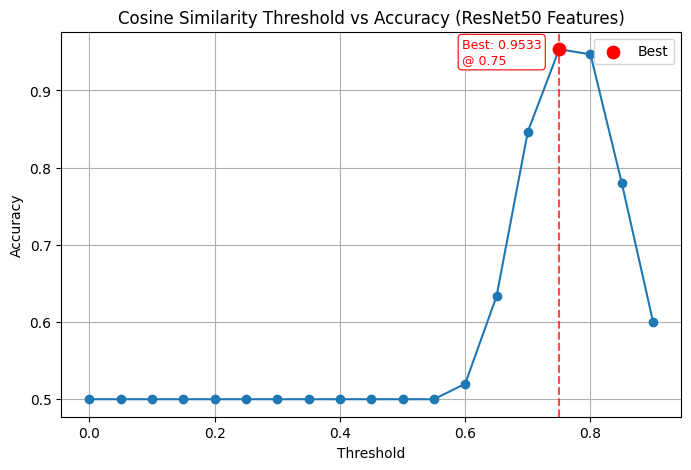

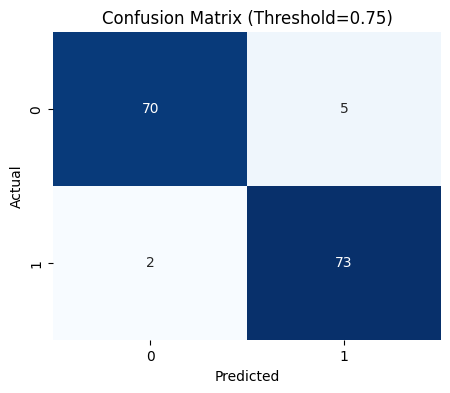

Best threshold: 0.75
Best accuracy: 0.9533333333333334
Best confusion matrix:
 [[70  5]
 [ 2 73]]


In [177]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.title("Cosine Similarity Threshold vs Accuracy (ResNet50 Features)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)

best_idx = thresholds.index(best_threshold)
plt.scatter(best_threshold, best_accuracy, color='red', s=80, zorder=5, label='Best')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.annotate(
    f"Best: {best_accuracy:.4f}\n@ {best_threshold:.2f}",
    (best_threshold, best_accuracy),
    textcoords="offset points",
    xytext=(-70, -10),
    ha='left',
    color='red',
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=0.8)
)
plt.legend()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Best threshold:", best_threshold)
print("Best accuracy:", best_accuracy)
print("Best confusion matrix:\n", best_cm)

In [178]:
cosine_misclassified_pairs = get_misclassified_pairs(df, image_feature_dict, method="cosine", threshold=best_threshold)
generate_misclassified_pdf(cosine_misclassified_pairs, "cosine_misclassified.pdf", "cosine", best_threshold)

Using threshold: 0.75
Number of misclassified pairs: 7
📄 PDF saved for cosine: cosine_misclassified.pdf


# Jaccard Similarity

In [147]:
def image_to_histogram_set(img_path, bins_per_channel=8):
    """
    Convert an image to a set of color histogram bins.
    We quantize the RGB space into bins_per_channel^3 bins.
    Each non-empty bin is treated as a 'visual token'.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))  # normalize size for consistency

    # Convert to numpy array
    img_array = np.array(img)

    # Quantize pixel values into bins
    bin_size = 256 // bins_per_channel
    quantized = (img_array // bin_size).astype(int)

    # Flatten to (num_pixels, 3)
    flat_pixels = quantized.reshape(-1, 3)

    # Convert each pixel to a single integer bin ID
    bin_ids = flat_pixels[:, 0] * (bins_per_channel ** 2) + flat_pixels[:, 1] * bins_per_channel + flat_pixels[:, 2]

    # Return the set of unique bins
    return set(bin_ids)


In [149]:
df = pd.read_excel('data/Paired Image.xlsx') 

In [150]:
print("Precomputing histogram sets for all images...")
all_image_paths = pd.concat([df['Image 1'], df['Image 2']]).unique()
hist_set_dict = {}
image_folder = "data/images"

for path in all_image_paths:
    full_path = os.path.join(image_folder, path)
    hist_set_dict[path] = image_to_histogram_set(full_path)

print(f"Extracted histogram sets for {len(hist_set_dict)} images.")

Precomputing histogram sets for all images...
Extracted histogram sets for 198 images.


In [151]:
thresholds = [i / 100 for i in range(10, 100, 5)]  # 0.10 → 0.95, step 0.05
accuracies = []
best_threshold = None
best_accuracy = -1
best_cm = None

for threshold in thresholds:
    y_true = []
    y_pred = []

    for _, row in df.iterrows():
        set1 = hist_set_dict[row['Image 1']]
        set2 = hist_set_dict[row['Image 2']]

        score = jaccard_similarity(set1, set2)
        pred = 1 if score > threshold else 0

        y_true.append(row['Similarity'])
        y_pred.append(pred)

    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_cm = cm

    print(f"Threshold {threshold:.2f} → Accuracy: {accuracy:.4f}")

Threshold 0.10 → Accuracy: 0.5051
Threshold 0.15 → Accuracy: 0.5051
Threshold 0.20 → Accuracy: 0.5354
Threshold 0.25 → Accuracy: 0.5556
Threshold 0.30 → Accuracy: 0.5758
Threshold 0.35 → Accuracy: 0.6061
Threshold 0.40 → Accuracy: 0.6465
Threshold 0.45 → Accuracy: 0.6667
Threshold 0.50 → Accuracy: 0.7980
Threshold 0.55 → Accuracy: 0.8182
Threshold 0.60 → Accuracy: 0.7980
Threshold 0.65 → Accuracy: 0.7576
Threshold 0.70 → Accuracy: 0.6667
Threshold 0.75 → Accuracy: 0.6061
Threshold 0.80 → Accuracy: 0.5455
Threshold 0.85 → Accuracy: 0.5152
Threshold 0.90 → Accuracy: 0.5051
Threshold 0.95 → Accuracy: 0.5051


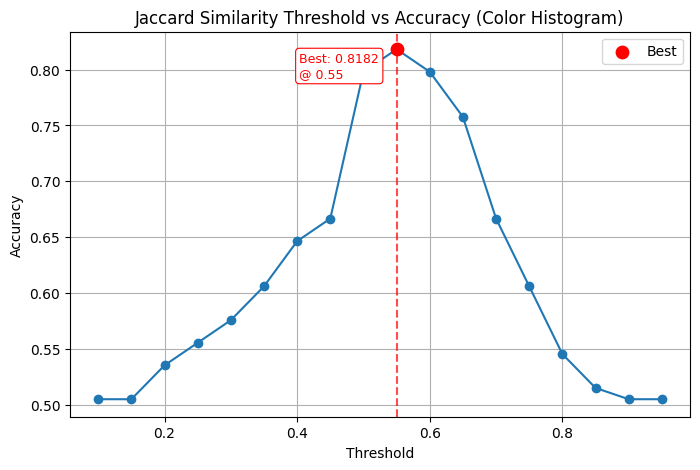

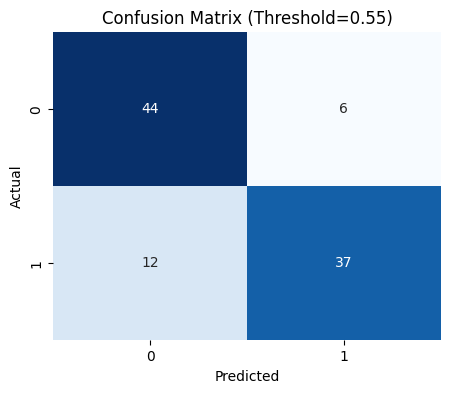

In [152]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.title("Jaccard Similarity Threshold vs Accuracy (Color Histogram)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)

best_idx = thresholds.index(best_threshold)
plt.scatter(best_threshold, best_accuracy, color='red', s=80, zorder=5, label='Best')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.annotate(
    f"Best: {best_accuracy:.4f}\n@ {best_threshold:.2f}",
    (best_threshold, best_accuracy),
    textcoords="offset points",
    xytext=(-70, -20),
    ha='left',
    color='red',
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=0.8)
)
plt.legend()
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Euclidean Distance

In [133]:
euclidean_scores = []

print("Precomputing Euclidean distances for all image pairs...")
for _, row in df.iterrows():
    feat1 = image_feature_dict[row['Image 1']]
    feat2 = image_feature_dict[row['Image 2']]
    dist = euclidean_distances([feat1], [feat2])[0][0]
    euclidean_scores.append(dist)

# Min–max normalize distances → similarity scores
min_dist = np.min(euclidean_scores)
max_dist = np.max(euclidean_scores)
euclidean_similarities = [1 - (d - min_dist) / (max_dist - min_dist) for d in euclidean_scores]

Precomputing Euclidean distances for all image pairs...


In [134]:
thresholds = [i / 100 for i in range(0, 95, 5)]  # 0.00 to 0.90, step 0.05
accuracies = []
best_threshold = None
best_accuracy = -1
best_cm = None

print("\nSweeping thresholds for Euclidean similarity...")
for threshold in thresholds:
    y_true = df['Similarity'].tolist()
    y_pred = [1 if score > threshold else 0 for score in euclidean_similarities]

    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold
        best_cm = cm

    print(f"Threshold {threshold:.2f} → Accuracy: {accuracy:.4f}")


Sweeping thresholds for Euclidean similarity...
Threshold 0.00 → Accuracy: 0.5051
Threshold 0.05 → Accuracy: 0.5253
Threshold 0.10 → Accuracy: 0.5657
Threshold 0.15 → Accuracy: 0.6061
Threshold 0.20 → Accuracy: 0.6869
Threshold 0.25 → Accuracy: 0.7576
Threshold 0.30 → Accuracy: 0.8283
Threshold 0.35 → Accuracy: 0.9192
Threshold 0.40 → Accuracy: 0.9091
Threshold 0.45 → Accuracy: 0.9192
Threshold 0.50 → Accuracy: 0.8990
Threshold 0.55 → Accuracy: 0.8485
Threshold 0.60 → Accuracy: 0.7778
Threshold 0.65 → Accuracy: 0.7374
Threshold 0.70 → Accuracy: 0.7071
Threshold 0.75 → Accuracy: 0.6667
Threshold 0.80 → Accuracy: 0.6061
Threshold 0.85 → Accuracy: 0.5354
Threshold 0.90 → Accuracy: 0.5253


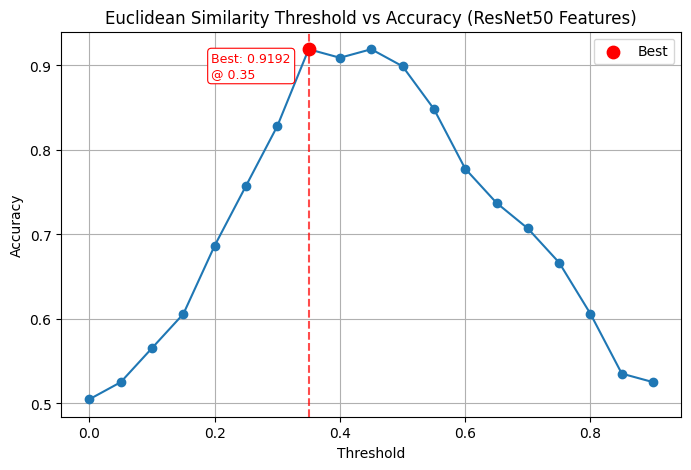

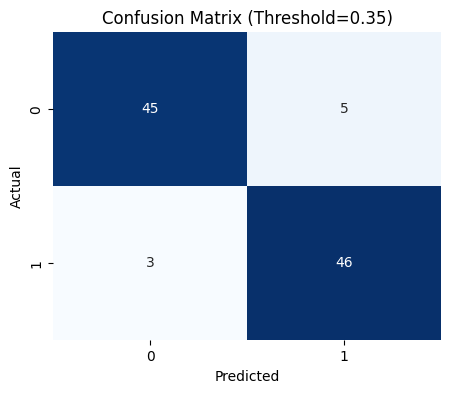

In [143]:
# --- STEP 3: Plot threshold vs accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, marker='o')
plt.title("Euclidean Similarity Threshold vs Accuracy (ResNet50 Features)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)

best_idx = thresholds.index(best_threshold)
plt.scatter(best_threshold, best_accuracy, color='red', s=80, zorder=5, label='Best')
plt.axvline(x=best_threshold, color='red', linestyle='--', alpha=0.7)
plt.annotate(
    f"Best: {best_accuracy:.4f}\n@ {best_threshold:.2f}",
    (best_threshold, best_accuracy),
    textcoords="offset points",
    xytext=(-70, -20),
    ha='left',
    color='red',
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=0.8)
)
plt.legend()
plt.show()

# --- STEP 4: Print best threshold and confusion matrix ---
plt.figure(figsize=(5, 4))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()